# Setup


In [1]:
%%capture
!pip install node2vec karateclub scikit-learn-extra python-louvain

In [2]:
%%capture
!git clone https://github.com/tjzetty/fairwalk.git

In [3]:
%%capture
%cd fairwalk/

In [4]:
%%capture
!python setup.py install

In [5]:
import numpy as np
import csv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import math

from community import community_louvain
from node2vec import Node2Vec
from fairwalk import FairWalk
from karateclub.node_embedding.neighbourhood import DeepWalk

from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.neighbors import NearestCentroid
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score, silhouette_samples, normalized_mutual_info_score

# Datasets

## Synthetic dataset

In [6]:
def generate_adja_SB_model(n, a, b, c, d, k, h, block_sizes):
    # Check if input is valid
    if (np.sum(block_sizes) != n) or (len(block_sizes) != (k * h)):
        raise ValueError('Wrong input')

    # Initialize adjacency matrix with edges present with probability d
    adja = np.random.binomial(1, d, (n, n))

    # Iterate over pairs of clusters and groups
    for ell in range(1, k+1):
        for mmm in range(1, k+1):
            for ggg in range(1, h+1):
                for fff in range(1, h+1):
                    # Modify adjacency matrix based on stochastic block model
                    if ell == mmm:
                        if ggg == fff:
                            # If within the same cluster and group, use probability a
                            start_row = np.sum(block_sizes[:(ell-1)*h + ggg-1])
                            end_row = np.sum(block_sizes[:(ell-1)*h + ggg])
                            start_col = np.sum(block_sizes[:(ell-1)*h + ggg-1])
                            end_col = np.sum(block_sizes[:(ell-1)*h + ggg])
                            shape = (int(end_row - start_row), int(end_col - start_col))
                            adja[int(start_row):int(end_row), int(start_col):int(end_col)] = np.random.binomial(1, a, shape)
                        else:
                            # If within the same cluster but different groups, use probability c
                            start_row_ggg = np.sum(block_sizes[:(ell-1)*h + ggg-1])
                            end_row_ggg = np.sum(block_sizes[:(ell-1)*h + ggg])
                            start_col_fff = np.sum(block_sizes[:(ell-1)*h + fff-1])
                            end_col_fff = np.sum(block_sizes[:(ell-1)*h + fff])
                            shape = (int(end_row_ggg - start_row_ggg), int(end_col_fff - start_col_fff))
                            adja[int(start_row_ggg):int(end_row_ggg), int(start_col_fff):int(end_col_fff)] = np.random.binomial(1, c, shape)
                    else:
                        if ggg == fff:
                            # If in different clusters but same group, use probability b
                            start_row_ell_ggg = np.sum(block_sizes[:(ell-1)*h + ggg-1])
                            end_row_ell_ggg = np.sum(block_sizes[:(ell-1)*h + ggg])
                            start_col_mmm_ggg = np.sum(block_sizes[:(mmm-1)*h + ggg-1])
                            end_col_mmm_ggg = np.sum(block_sizes[:(mmm-1)*h + ggg])
                            shape = (int(end_row_ell_ggg - start_row_ell_ggg), int(end_col_mmm_ggg - start_col_mmm_ggg))
                            adja[int(start_row_ell_ggg):int(end_row_ell_ggg), int(start_col_mmm_ggg):int(end_col_mmm_ggg)] = np.random.binomial(1, b, shape)

    # Create final adjacency matrix by taking the upper triangular part and adding its transpose
    A = np.triu(adja, 1)
    A = A + A.T
    return A

# Representations

In [7]:
def get_n2v_embed(graph, p=1, q=1, walk_length=30):
  # node2vec parameters
  dimensions = 16
  num_walks = 100
  # Create and train the node2vec model
  model = Node2Vec(graph, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, p=p, q=q, seed=42).fit(window=10, min_count=1, batch_words=4)

  # Get the embeddings for all nodes
  n2v_emb = np.array([model.wv.word_vec(str(node)) for node in graph.nodes()])
  return n2v_emb

In [8]:
def get_dw_embed(graph, walk_length=30):
  dimensions = 16
  # Create and train the deepwalk model
  model = DeepWalk(dimensions=dimensions, walk_length=walk_length, window_size=10, min_count=1, seed=42)
  model.fit(graph)

  # Get the embeddings for all nodes
  dw_emb = model.get_embedding()
  return dw_emb

In [9]:
def get_fw_embed(graph, group_labels,p=1, q=1, walk_length=30):
  dimensions = 16
  num_walks = 100

  n = len(graph.nodes())
  node2group = {node: group for node, group in zip(graph.nodes(), group_labels)}
  nx.set_node_attributes(graph, node2group, 'group')

  # Create and train the fairwalk model
  model = FairWalk(graph, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks).fit(window=10, min_count=1, batch_words=4)

  # Get the embeddings for all nodes
  fw_emb = np.array([model.wv.word_vec(str(node)) for node in graph.nodes()])
  return fw_emb

# Helper functions
* for computing modularity


In [10]:
def cl_labels_to_communities(arr):
    indices_dict = {}
    for i, value in enumerate(arr):
        if value not in indices_dict:
            indices_dict[value] = [i]
        else:
            indices_dict[value].append(i)
    return [set(indices) for indices in indices_dict.values()]

# Fairness notion
* balance(f) := min{ri/ri(f), ri(f)/ri} ∀i ∈ [ℓ], where  ri:= |Ci|/|C| and ri(f) := |Ci(f)|/|C(f)|.

In [11]:
def get_balance_score(dataset_ratio, cluster_ratio):
  balance_score = np.min(np.min(np.minimum(dataset_ratio/cluster_ratio, cluster_ratio/dataset_ratio), axis=1))
  return np.round(balance_score, 3)

# Vanilla clustering

In [13]:
def vanilla_kmeans(X, n_clusters):
  kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42).fit(X)
  cluster_assignments = kmeans.labels_
  dist_centers = kmeans.transform(X)
  return cluster_assignments, dist_centers

In [14]:
def vanilla_kmedoid(X, n_clusters):
  kmedoids = KMedoids(n_clusters=n_clusters, random_state=42).fit(X)
  cluster_assignments = kmedoids.labels_
  dist_centers = kmedoids.transform(X)
  return cluster_assignments, dist_centers


In [15]:
def vanilla_aggl_cl(X, n_clusters):
  clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
  cluster_assignments = clustering.labels_
  # Find centroids
  clf = NearestCentroid()
  clf.fit(X, cluster_assignments)
  centroids = clf.centroids_

  dist_centers = euclidean_distances(X, centroids)
  return cluster_assignments, dist_centers

In [16]:
def vanilla_spectral_cl(X, n_clusters):
  clustering = SpectralClustering(n_clusters=n_clusters, random_state=42).fit(X)
  cluster_assignments = clustering.labels_
  # Find centroids
  clf = NearestCentroid()
  clf.fit(X, cluster_assignments)
  centroids = clf.centroids_
  # Get euclidean distances
  dist_centers = euclidean_distances(X, centroids)
  return cluster_assignments, dist_centers

# Post-processing step

In [17]:
def get_group_frac_per_cluster(cl_labels, colors, n_clusters):
  """
  Get the proportion of groups in each cluster
  """
  groups_per_cluster = np.zeros((n_clusters, np.unique(colors).shape[0]))
  group_distr = np.zeros((n_clusters, np.unique(colors).shape[0]))
  for cluster in np.unique(cl_labels):
    for i, group in enumerate(np.unique(colors)):
        group_per_cluster_count = np.count_nonzero((cl_labels == cluster) & (colors == group))
        groups_per_cluster[cluster, i] = group_per_cluster_count
        group_distr[cluster, i] = group_per_cluster_count / np.count_nonzero((cl_labels == cluster))
  return group_distr

In [18]:
def post_processing_step(cluster_assignments, labels, dist_centers, representation, err=0.01):
    total_points = len(labels)
    num_clusters = np.unique(cluster_assignments).shape[0]

    # The desired group distribution per cluster
    group_fractions = np.array([np.sum(labels == label) / total_points for label in np.unique(labels)])

    fair_group_distr = np.tile(group_fractions,(num_clusters,1))

    # current distribution of groups in clusters
    curr_group_distr = get_group_frac_per_cluster(cluster_assignments, labels, num_clusters)
    group_distr_diff = curr_group_distr - fair_group_distr
    vanilla_balance_score = get_balance_score(fair_group_distr, curr_group_distr)
    balance_score = vanilla_balance_score

    new_cluster_assignments = cluster_assignments.copy()
    # While there exists overrepresented groups or the alg reached the max iterations
    # reassign the most distant points that belong to the overrepresented group
    # to the next nearest cluster that the specific group is underrepresented
    stop = 0
    while np.any(group_distr_diff > err) and stop < 110:
      for cluster_id in range(num_clusters):
        for i, label in enumerate(np.unique(labels)):
            if group_distr_diff[(cluster_id, i)] > err:
              # Select the most distant point and assign it to the nearest unfair cluster
              indices_to_move = np.where((new_cluster_assignments == cluster_id) & (labels == label))[0]
              # The point which has the maximum distance from its cluster center and belongs to an overrepresented class
              max_dist_index = indices_to_move[np.argmax(dist_centers[indices_to_move], axis=0)[cluster_id]]
              # Get the nearest cluster of this point, that is also unfair in terms of the same group label
              unfair_cluster_indices, underrepr_group_indices = np.where(group_distr_diff < 0.)
              unfair_underrepr_clusters = unfair_cluster_indices[np.where(underrepr_group_indices==i)]
              next_nearest_cluster = np.argsort(dist_centers[max_dist_index, np.insert(unfair_underrepr_clusters, 0, cluster_id)], axis=0)[1]
              new_cluster_assignments[max_dist_index] = next_nearest_cluster

              # Update the current distribution
              curr_group_distr = get_group_frac_per_cluster(new_cluster_assignments, labels, num_clusters)
              group_distr_diff = curr_group_distr - fair_group_distr
              balance_score = get_balance_score(fair_group_distr, curr_group_distr)

      stop += 1

    return new_cluster_assignments, balance_score, vanilla_balance_score


# Experiments

## Fair clustering for synthetic dataset
* num clusters = 4
* num groups = 2
* num points = 240

In [19]:
n = 240 # n, number of nodes
a, b, c, d = 0.1, 0.05, 0.025, 0.0125

k, h = 4, 2 # where k is the number of clusters, and h the number of groups
block_sizes = [30] * k * h

adj_matrix = generate_adja_SB_model(n, a, b, c, d, k, h, block_sizes)

# Ground truth cluster labels
gt_cl_labels = np.concatenate((np.zeros(60), np.ones(60), (np.full((60,), 2)), (np.full((60,), 3)))).astype(int)
# Ground truth group labels
colors = np.concatenate([np.full(30, 2), np.full(30, 3)] * 4)

In [20]:
# Create a NetworkX graph from the adjacency matrix
G = nx.from_numpy_array(adj_matrix)
# get the largest connected component graph
largest = max(nx.connected_components(G), key=len)
G = nx.Graph(G)

# init embeddings dict
embeds = {}

In [22]:
%%capture
# param pairs
params = [(1, 2, 15), (1, 0.5, 15), (0.5, 1, 15), (2, 1, 15)]

# Get node2vec embeddings
for param in params:
  p, q, walk_length = param
  n2v_emb = get_n2v_embed(G, p=p, q=q, walk_length=walk_length)
  embeds[f"node2vec_{p}_{q}"] = n2v_emb

In [23]:
%%capture
# get deepwalk embeddings
walk_length = 15
dw_emb = get_dw_embed(G, walk_length=walk_length)
embeds["deepwalk"] = dw_emb

In [24]:
%%capture
# param pairs
params = [(1, 2, 15), (1, 0.5, 15), (0.5, 1, 15), (2, 1, 15)]

# Get fairwalk embeddings
for param in params:
  p, q, walk_length = param
  fw_emb = get_fw_embed(G, colors, p=p, q=q, walk_length=walk_length)
  embeds[f"fairwalk_{p}_{q}"] = n2v_emb

In [25]:
cl_algs = {
    'kmeans': vanilla_kmeans,
    'kmedoids': vanilla_kmedoid,
    'agglomerative clust.': vanilla_aggl_cl,
    'spectral clustering': vanilla_spectral_cl
    }

In [26]:
%%capture
res = pd.DataFrame(columns = ['embed', 'cl_alg', 'vanilla_balance', 'fair_balance', 'gt_modularity', 'vanilla_modularity', 'fair_modularity', 'gt_sil', 'vanilla_sil', 'fair_sil', 'vanilla_nmi', 'fair_nmi'])
for embed_name, embed in embeds.items():
  for cl_alg_name, cl_alg in cl_algs.items():
    vanilla_cl_labels, cl_dist_centers = cl_alg(embed, n_clusters=k)

    fair_cl_labels, fair_balance, vanilla_balance = post_processing_step(
        vanilla_cl_labels, colors, cl_dist_centers, embed
    )
    # Extract the communities from clustering
    gt_comm = cl_labels_to_communities(gt_cl_labels)
    vanilla_comm = cl_labels_to_communities(vanilla_cl_labels)
    fair_comm = cl_labels_to_communities(fair_cl_labels)

    cl_alg_res = {
        'embed': embed_name,
        'cl_alg': cl_alg_name,
        'gt_modularity': round(nx.community.modularity(G, gt_comm), 3),
        'gt_sil': round(silhouette_score(embed, gt_cl_labels), 3),
        'vanilla_balance': vanilla_balance,
        'vanilla_modularity': round(nx.community.modularity(G, vanilla_comm), 3),
        'vanilla_sil': round(silhouette_score(embed, vanilla_cl_labels), 3),
        'vanilla_nmi': round(normalized_mutual_info_score(gt_cl_labels, vanilla_cl_labels), 3),
        'fair_balance': fair_balance,
        'fair_modularity': round(nx.community.modularity(G, fair_comm), 3),
        'fair_sil':  round(silhouette_score(embed, fair_cl_labels), 3),
        'fair_nmi': round(normalized_mutual_info_score(gt_cl_labels, fair_cl_labels), 3),
    }

    res = res.append(cl_alg_res, ignore_index = True)

In [27]:
res

,embed,cl_alg,vanilla_balance,fair_balance,gt_modularity,vanilla_modularity,fair_modularity,gt_sil,vanilla_sil,fair_sil,vanilla_nmi,fair_nmi
0,node2vec_1_2,kmeans,0.000,0.000,0.25,0.388,0.288,-0.005,0.066,0.005,0.019,0.022
1,node2vec_1_2,kmedoids,0.692,0.764,0.25,0.302,0.279,-0.005,0.033,0.025,0.028,0.024
2,node2vec_1_2,agglomerative clust.,0.100,0.923,0.25,0.393,0.165,-0.005,0.055,-0.028,0.021,0.038
3,node2vec_1_2,spectral clustering,0.030,1.000,0.25,0.380,0.107,-0.005,0.082,-0.039,0.017,0.017
4,node2vec_1_0.5,kmeans,0.000,0.000,0.25,0.368,0.344,-0.005,0.069,0.038,0.018,0.022
5,node2vec_1_0.5,kmedoids,0.282,1.000,0.25,0.342,0.208,-0.005,0.041,-0.014,0.024,0.028
6,node2vec_1_0.5,agglomerative clust.,0.111,1.000,0.25,0.372,0.165,-0.005,0.057,-0.037,0.015,0.023
7,node2vec_1_0.5,spectral clustering,0.065,0.241,0.25,0.377,0.245,-0.005,0.075,-0.030,0.032,0.041
8,node2vec_0.5_1,kmeans,0.034,1.000,0.25,0.392,0.206,-0.007,0.068,-0.046,0.006,0.013
9,node2vec_0.5_1,kmedoids,0.148,1.000,0.25,0.341,0.248,-0.007,0.041,-0.005,0.029,0.041


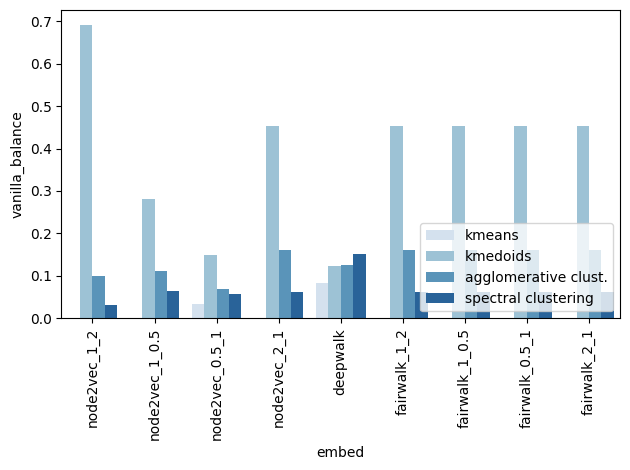

In [29]:
sns.barplot(x = 'embed',
            y = 'vanilla_balance',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("synth_4cl_vanilla_balance.png")
plt.show()

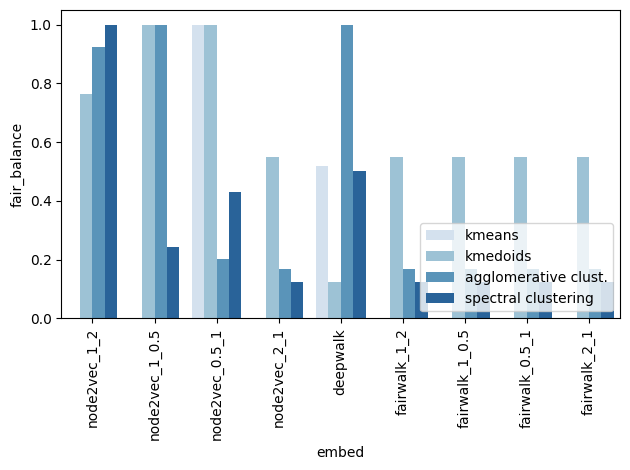

In [30]:
sns.barplot(x = 'embed',
            y = 'fair_balance',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("synth_4cl_fair_balance.png")
plt.show()

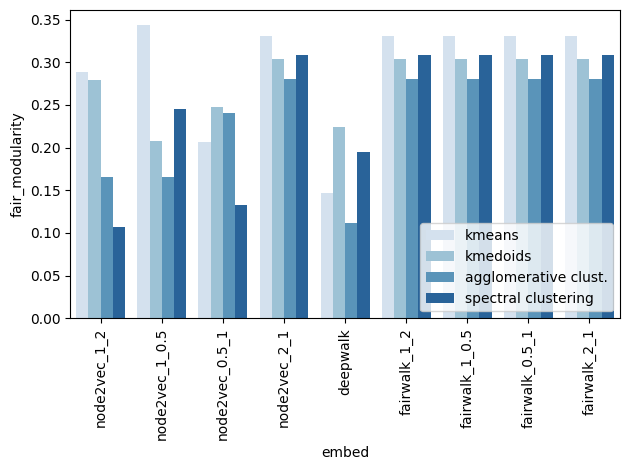

In [31]:
sns.barplot(x = 'embed',
            y = 'fair_modularity',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("synth_4cl_fair_modularity.png")
plt.show()

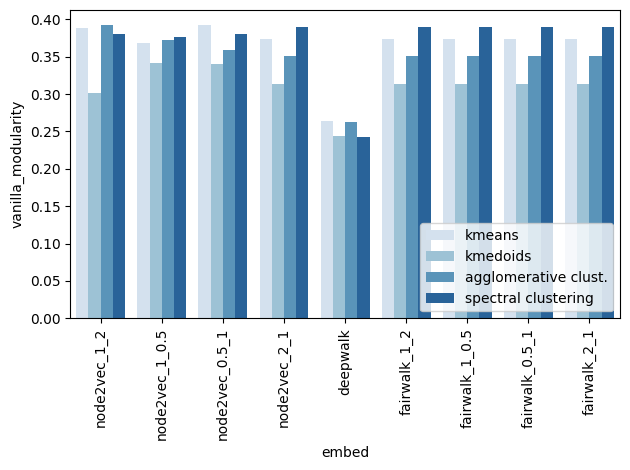

In [32]:
sns.barplot(x = 'embed',
            y = 'vanilla_modularity',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("synth_4cl_vanilla_modularity.png")
plt.show()

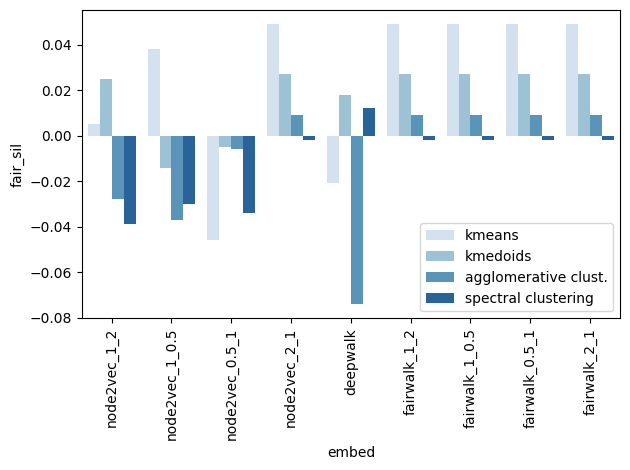

In [33]:
sns.barplot(x = 'embed',
            y = 'fair_sil',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("synth_4cl_fair_sil.png")
plt.show()

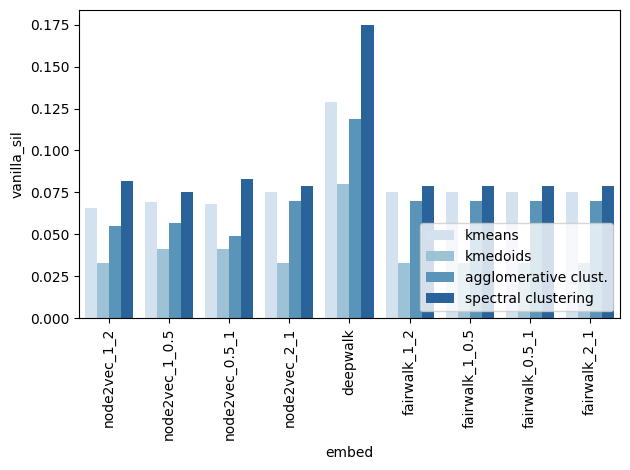

In [34]:
sns.barplot(x = 'embed',
            y = 'vanilla_sil',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("synth_4cl_vanilla_sil.png")

plt.show()

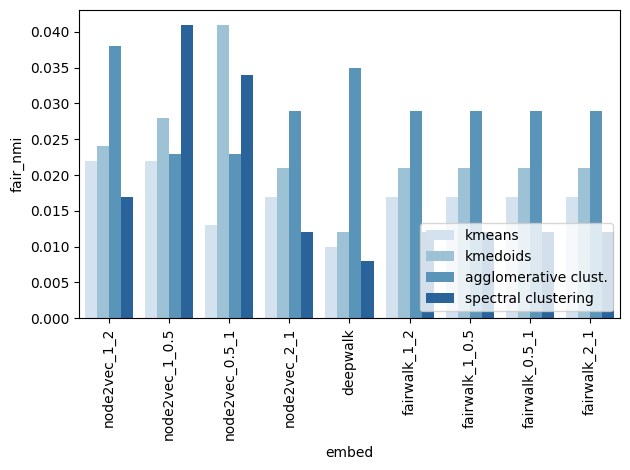

In [35]:
sns.barplot(x = 'embed',
            y = 'fair_nmi',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("synth_4cl_fair_nmi.png")
plt.show()

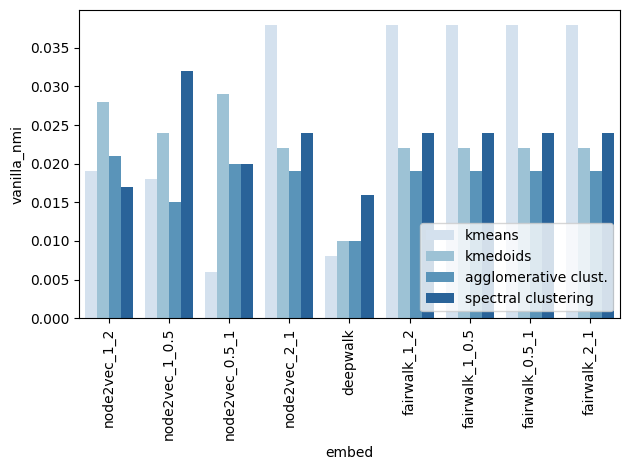

In [36]:
sns.barplot(x = 'embed',
            y = 'vanilla_nmi',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("synth_4cl_vanilla_nmi.png")
plt.show()

## Fair clustering for FRIENDSHIPNET
* FRIENDSHIPNET dataset: http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/

In [19]:
%%capture
%cd /content
!gdown 1rMC8xr_9VDoWidgTP9ZGpXAZn72pDyMB
!gdown 1R1sGNoYuRZ16UETX9KvMHOlC4vTOq0Re

In [20]:
G = nx.read_edgelist('Friendship-network_data_2013.csv', create_using=nx.Graph(), nodetype=int)
print(f"Init:\nnumber of nodes: {len(G.nodes())}, number of edges: {len(G.edges())}")

Init:
number of nodes: 134, number of edges: 406


In [21]:
# get ground truth clusters and groups
metadata = pd.read_csv('frienship_facebook_metadata_2013.txt', sep='\t', header=None)
metadata.columns = ['node', 'class', 'group']

# Remove nodes where the group category is unknown
unkn_group_metadata = metadata.loc[metadata.group=='Unknown']
unkn_group_nodes = unkn_group_metadata.node

metadata.drop(unkn_group_metadata.index, inplace=True)
# Remove these nodes from graph too
G.remove_nodes_from(unkn_group_nodes)
print(f'After removal of nodes with unkn group:\nnumber of nodes: {len(G.nodes())}, number of edges: {len(G.edges())}')

# Get the largest connected component graph
largest_comp = max(nx.connected_components(G), key=len)
largest_subg = G.subgraph(largest_comp)
G = nx.Graph(largest_subg)
print(f'After getting the largest connected component:\nnumber of nodes: {len(G.nodes())}, number of edges: {len(G.edges())}')

# Relabel nodes to consecutive integers
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default')
# create node id in metadata to be aligned with G
metadata['node_id'] = metadata.index

After removal of nodes with unkn group:
number of nodes: 133, number of edges: 401
After getting the largest connected component:
number of nodes: 127, number of edges: 396


In [22]:
metadata[['class', 'group']] = metadata[['class', 'group']].astype('category')
cat_columns = metadata.select_dtypes(['category']).columns
metadata[cat_columns] = metadata[cat_columns].apply(lambda x: x.cat.codes)

In [23]:
# Get the groups
colors = np.array([metadata.loc[metadata.node_id==node, 'group'].iloc[0] for node in G.nodes()])
unique_colors, counts = np.unique(colors, return_counts=True)
n_colors = len(unique_colors)
print(f"n_colors: {n_colors}, number of nodes per group: {counts}")

n_colors: 2, number of nodes per group: [85 42]


In [27]:
# Get louvain best modularity partitioning to define k
partition = community_louvain.best_partition(G, random_state=433)
lv_cl_labels = list(partition.values())

# Louvain clusters
unique_clusters, counts = np.unique(lv_cl_labels, return_counts=True)
n_clusters = len(unique_clusters)
print(f"Louvain:\nn_clusters: {n_clusters}, number of nodes per cluster: {counts/len(G.nodes())}")


Louvain:
n_clusters: 8, number of nodes per cluster: [0.18897638 0.13385827 0.11811024 0.1496063  0.07086614 0.03937008
 0.14173228 0.15748031]


In [28]:
# Get louvain partition modularity
lv_modularity = community_louvain.modularity(partition, G)
print(f'modularity: {lv_modularity:.3f}')

# Get louvain balance
total_points = len(lv_cl_labels)
group_fractions = np.array([np.sum(colors == color) / total_points for color in np.unique(colors)])
fair_group_distr = np.tile(group_fractions,(n_clusters, 1))
lv_group_distr = get_group_frac_per_cluster(lv_cl_labels, colors, n_clusters)
lv_balance = get_balance_score(fair_group_distr, lv_group_distr)
print(f'balance: {lv_balance}')

modularity: 0.705
balance: 0.735


In [29]:
# Init embedddings dict
embeds = {}

In [30]:
%%capture
# param pairs
params = [(1, 2, 15), (1, 0.5, 15), (0.5, 1, 15), (2, 1, 15)]

# Get node2vec embeddings
for param in params:
  p, q, walk_length = param
  n2v_emb = get_n2v_embed(G, p=p, q=q, walk_length=walk_length)
  embeds[f"node2vec_{p}_{q}"] = n2v_emb

In [31]:
%%capture
# get deepwalk embeddings
dw_emb = get_dw_embed(G, walk_length=walk_length)
embeds["deepwalk"] = dw_emb

In [32]:
%%capture
# param pairs
params = [(1, 2, 15), (1, 0.5, 15), (0.5, 1, 15), (2, 1, 15)]

# Get node2vec embeddings
for param in params:
  p, q, walk_length = param
  fw_emb = get_fw_embed(G, colors, p=p, q=q, walk_length=walk_length)
  embeds[f"fairwalk_{p}_{q}"] = n2v_emb

In [33]:
cl_algs = {
    'kmeans': vanilla_kmeans,
    'kmedoids': vanilla_kmedoid,
    'agglomerative clust.': vanilla_aggl_cl,
    'spectral clustering': vanilla_spectral_cl
    }

In [51]:
%%capture
res = pd.DataFrame(columns = ['embed', 'cl_alg', 'lv_balance', 'vanilla_balance', 'fair_balance', 'lv_modularity', 'vanilla_modularity', 'fair_modularity', 'lv_sil','vanilla_sil', 'fair_sil', 'vanilla_nmi', 'fair_nmi'])
for embed_name, embed in embeds.items():
  for cl_alg_name, cl_alg in cl_algs.items():
    vanilla_cl_labels, cl_dist_centers = cl_alg(embed, n_clusters=n_clusters)

    fair_cl_labels, fair_balance, vanilla_balance = post_processing_step(
        vanilla_cl_labels, colors, cl_dist_centers, embed
    )

    # Extract the communities from clustering
    vanilla_comm = cl_labels_to_communities(vanilla_cl_labels)
    fair_comm = cl_labels_to_communities(fair_cl_labels)

    cl_alg_res = {
        'embed': embed_name,
        'cl_alg': cl_alg_name,

        'lv_balance': lv_balance,
        'vanilla_balance': vanilla_balance,
        'fair_balance': fair_balance,

        'lv_modularity': round(lv_modularity, 3),
        'vanilla_modularity': round(nx.community.modularity(G, vanilla_comm), 3),
        'fair_modularity': round(nx.community.modularity(G, fair_comm), 3),

        'lv_sil': round(silhouette_score(embed, lv_cl_labels), 3),
        'vanilla_sil': round(silhouette_score(embed, vanilla_cl_labels), 3),
        'fair_sil':  round(silhouette_score(embed, fair_cl_labels), 3),

        'vanilla_nmi': round(normalized_mutual_info_score(lv_cl_labels, vanilla_cl_labels), 3),
        'fair_nmi': round(normalized_mutual_info_score(lv_cl_labels, fair_cl_labels), 3),
    }

    res = res.append(cl_alg_res, ignore_index = True)

In [52]:
res

,embed,cl_alg,lv_balance,vanilla_balance,fair_balance,lv_modularity,vanilla_modularity,fair_modularity,lv_sil,vanilla_sil,fair_sil,vanilla_nmi,fair_nmi
0,node2vec_1_2,kmeans,0.735,0.595,0.972,0.705,0.702,0.653,0.305,0.277,0.204,0.824,0.706
1,node2vec_1_2,kmedoids,0.735,0.000,0.756,0.705,0.709,0.663,0.305,0.244,0.173,0.761,0.654
2,node2vec_1_2,agglomerative clust.,0.735,0.735,0.955,0.705,0.733,0.698,0.305,0.293,0.212,0.944,0.797
3,node2vec_1_2,spectral clustering,0.735,0.496,0.827,0.705,0.706,0.650,0.305,0.264,0.178,0.807,0.656
4,node2vec_1_0.5,kmeans,0.735,0.427,0.672,0.705,0.721,0.650,0.296,0.297,0.163,0.779,0.646
5,node2vec_1_0.5,kmedoids,0.735,0.000,0.529,0.705,0.635,0.562,0.296,0.186,0.077,0.668,0.558
6,node2vec_1_0.5,agglomerative clust.,0.735,0.735,0.968,0.705,0.735,0.667,0.296,0.313,0.220,0.898,0.754
7,node2vec_1_0.5,spectral clustering,0.735,0.756,0.756,0.705,0.723,0.683,0.296,0.311,0.240,0.849,0.779
8,node2vec_0.5_1,kmeans,0.735,0.477,0.756,0.705,0.683,0.631,0.289,0.219,0.138,0.774,0.629
9,node2vec_0.5_1,kmedoids,0.735,0.000,0.000,0.705,0.656,0.589,0.289,0.200,0.138,0.767,0.626


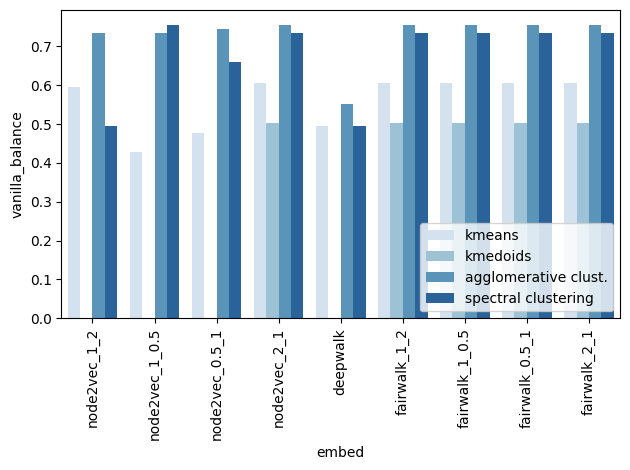

In [54]:
sns.barplot(x = 'embed',
            y = 'vanilla_balance',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("friendship_vanilla_balance.png")
plt.show()

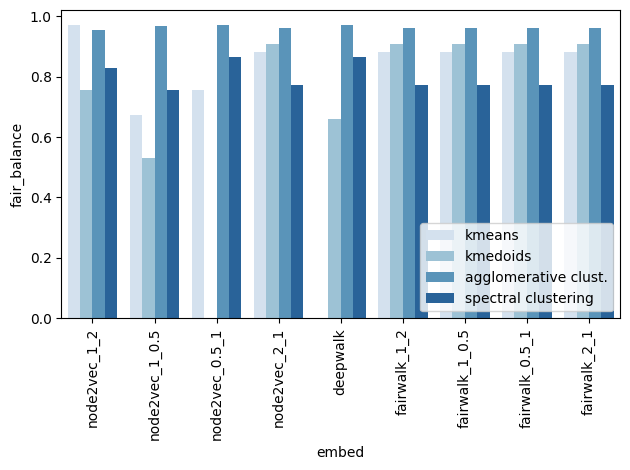

In [55]:
sns.barplot(x = 'embed',
            y = 'fair_balance',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("friendship_fair_balance.png")
plt.show()

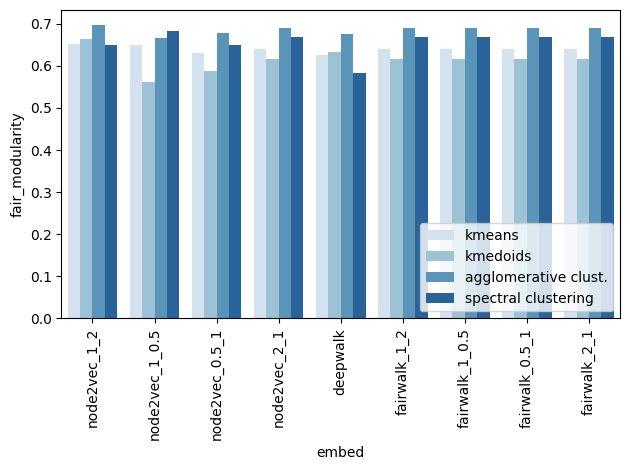

In [56]:
sns.barplot(x = 'embed',
            y = 'fair_modularity',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("friendship_fair_modularity.png")
plt.show()

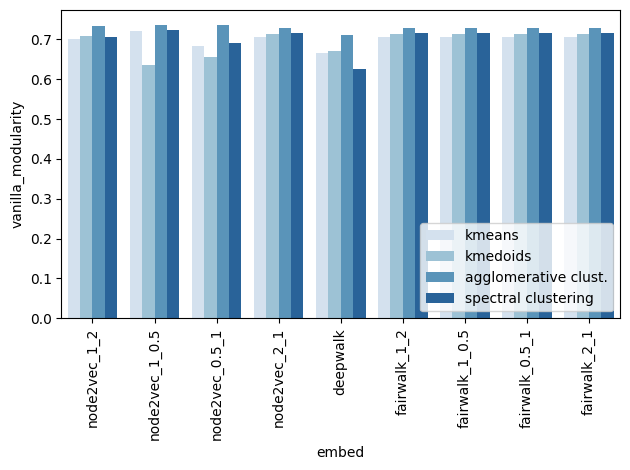

In [57]:
sns.barplot(x = 'embed',
            y = 'vanilla_modularity',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("friendship_vanilla_modularity.png")
plt.show()

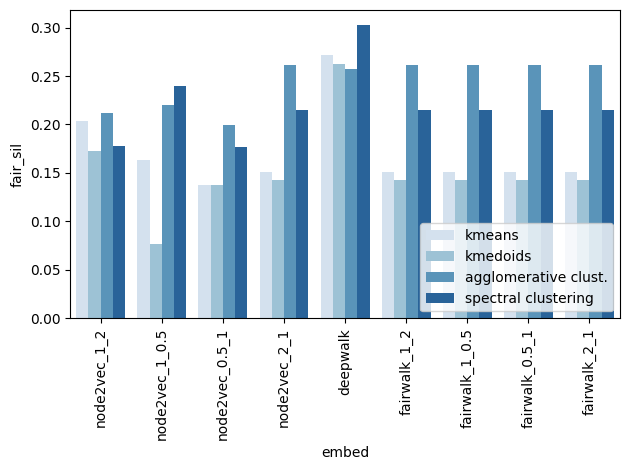

In [58]:
sns.barplot(x = 'embed',
            y = 'fair_sil',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("friendship_fair_sil.png")
plt.show()

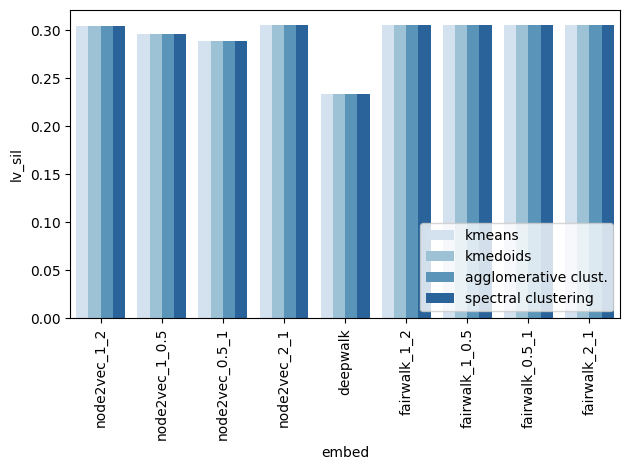

In [60]:
sns.barplot(x = 'embed',
            y = 'lv_sil',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("friendship_lv_sil.png")

plt.show()

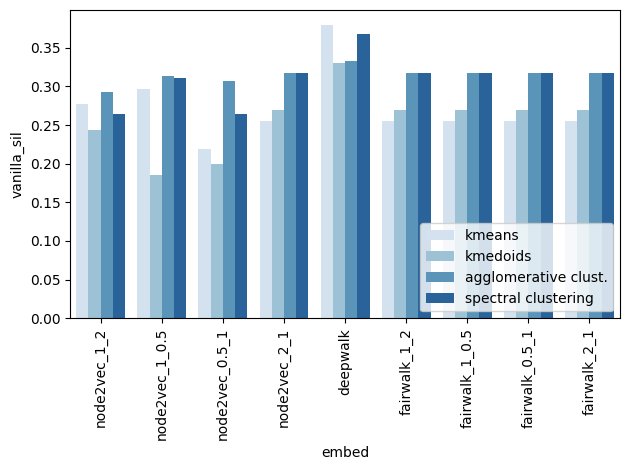

In [59]:
sns.barplot(x = 'embed',
            y = 'vanilla_sil',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("friendship_vanilla_sil.png")

plt.show()

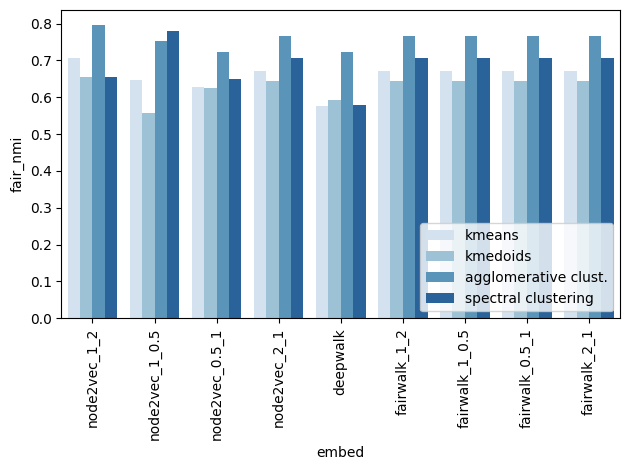

In [61]:
sns.barplot(x = 'embed',
            y = 'fair_nmi',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("friendship_fair_nmi.png")
plt.show()

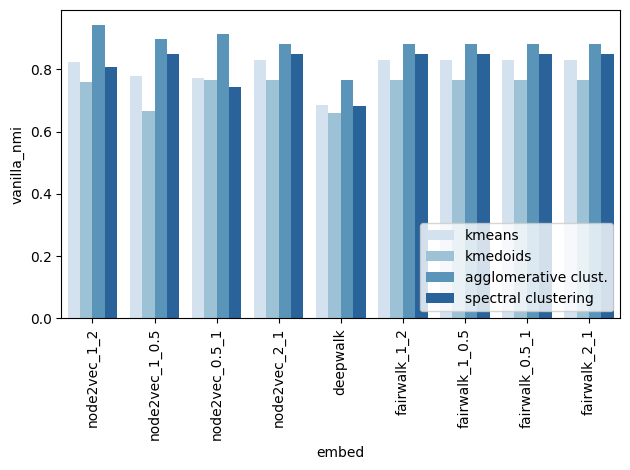

In [62]:
sns.barplot(x = 'embed',
            y = 'vanilla_nmi',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("friendship_vanilla_nmi.png")
plt.show()

## Fair clustering for FacebookNet
* * FacebookNet dataset: http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/

In [19]:
%%capture
%cd /content
!gdown 1hj0pI4-zDYyCplXT4jb36LZpBs4q0Yhi
!gdown 1R1sGNoYuRZ16UETX9KvMHOlC4vTOq0Re

/content
Downloading...
From: https://drive.google.com/uc?id=1hj0pI4-zDYyCplXT4jb36LZpBs4q0Yhi
To: /content/Facebook-known-pairs_data_2013.csv
100% 45.2k/45.2k [00:00<00:00, 50.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1R1sGNoYuRZ16UETX9KvMHOlC4vTOq0Re
To: /content/frienship_facebook_metadata_2013.txt
100% 3.57k/3.57k [00:00<00:00, 10.1MB/s]


In [25]:
# covert node i, node j, weight (0,1) to an edge list, keeping only the positive weight edges
edgelist_df = pd.read_csv('Facebook-known-pairs_data_2013.csv', sep=' ', header=None)
edgelist_df.columns = ['node_i', 'node_j', 'weight']
edgelist_df = edgelist_df.loc[edgelist_df.weight==1][['node_i', 'node_j']]
edgelist_df.to_csv('edgelist.csv', index=False, sep=' ', header=False)

In [26]:
# G = nx.from_numpy_array(edgelist, create_using=nx.Graph())
G = nx.read_edgelist('edgelist.csv', create_using=nx.Graph(), nodetype=int)

print(f"Init:\nnumber of nodes: {len(G.nodes())}, number of edges: {len(G.edges())}")

Init:
number of nodes: 156, number of edges: 1437


In [27]:
# get ground truth clusters and groups
metadata = pd.read_csv('frienship_facebook_metadata_2013.txt', sep='\t', header=None)
metadata.columns = ['node', 'class', 'group']

# Remove nodes where the group category is unknown
unkn_group_metadata = metadata.loc[metadata.group=='Unknown']
unkn_group_nodes = unkn_group_metadata.node

metadata.drop(unkn_group_metadata.index, inplace=True)
# Remove these nodes from graph too
G.remove_nodes_from(unkn_group_nodes)
print(f'After removal of nodes with unkn group:\nnumber of nodes: {len(G.nodes())}, number of edges: {len(G.edges())}')

# Get the largest connected component graph
largest_comp = max(nx.connected_components(G), key=len)
largest_subg = G.subgraph(largest_comp)
G = nx.Graph(largest_subg)
print(f'After getting the largest connected component:\nnumber of nodes: {len(G.nodes())}, number of edges: {len(G.edges())}')

# Relabel nodes to consecutive integers
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default')
# create node id in metadata to be aligned with G
metadata['node_id'] = metadata.index

After removal of nodes with unkn group:
number of nodes: 155, number of edges: 1412
After getting the largest connected component:
number of nodes: 155, number of edges: 1412


In [28]:
metadata[['class', 'group']] = metadata[['class', 'group']].astype('category')
cat_columns = metadata.select_dtypes(['category']).columns
metadata[cat_columns] = metadata[cat_columns].apply(lambda x: x.cat.codes)

In [29]:
# Get the groups
colors = np.array([metadata.loc[metadata.node_id==node, 'group'].iloc[0] for node in G.nodes()])
unique_colors, counts = np.unique(colors, return_counts=True)
n_colors = len(unique_colors)
print(f"n_colors: {n_colors}, number of nodes per group: {counts}")

n_colors: 2, number of nodes per group: [90 65]


In [30]:
# Get louvain best modularity partitioning to define k
partition = community_louvain.best_partition(G, random_state=433)
lv_cl_labels = list(partition.values())

# Louvain clusters
unique_clusters, counts = np.unique(lv_cl_labels, return_counts=True)
n_clusters = len(unique_clusters)
print(f"Louvain:\nn_clusters: {n_clusters}, number of nodes per cluster: {counts/len(G.nodes())}")

Louvain:
n_clusters: 6, number of nodes per cluster: [0.20645161 0.2516129  0.10967742 0.15483871 0.15483871 0.12258065]


In [31]:
# Get louvain partition modularity
lv_modularity = community_louvain.modularity(partition, G)
print(f'modularity: {lv_modularity:.3f}')

# Get louvain balance
total_points = len(lv_cl_labels)
group_fractions = np.array([np.sum(colors == color) / total_points for color in np.unique(colors)])
fair_group_distr = np.tile(group_fractions,(n_clusters, 1))
lv_group_distr = get_group_frac_per_cluster(lv_cl_labels, colors, n_clusters)
lv_balance = get_balance_score(fair_group_distr, lv_group_distr)
print(f'balance: {lv_balance}')

modularity: 0.527
balance: 0.373


In [32]:
# Init embedddings dict
embeds = {}

In [33]:
%%capture
# param pairs
params = [(1, 2, 15), (1, 0.5, 15), (0.5, 1, 15), (2, 1, 15)]

# Get node2vec embeddings
for param in params:
  p, q, walk_length = param
  n2v_emb = get_n2v_embed(G, p=p, q=q, walk_length=walk_length)
  embeds[f"node2vec_{p}_{q}"] = n2v_emb

In [ ]:
%%capture
# get deepwalk embeddings
dw_emb = get_dw_embed(G, walk_length=walk_length)
embeds["deepwalk"] = dw_emb

In [35]:
%%capture
# param pairs
params = [(1, 2, 15), (1, 0.5, 15), (0.5, 1, 15), (2, 1, 15)]

# Get node2vec embeddings
for param in params:
  p, q, walk_length = param
  fw_emb = get_fw_embed(G, colors, p=p, q=q, walk_length=walk_length)
  embeds[f"fairwalk_{p}_{q}"] = n2v_emb

In [36]:
cl_algs = {
    'kmeans': vanilla_kmeans,
    'kmedoids': vanilla_kmedoid,
    'agglomerative clust.': vanilla_aggl_cl,
    'spectral clustering': vanilla_spectral_cl
    }

In [37]:
%%capture
res = pd.DataFrame(columns = ['embed', 'cl_alg', 'lv_balance', 'vanilla_balance', 'fair_balance', 'lv_modularity', 'vanilla_modularity', 'fair_modularity', 'lv_sil','vanilla_sil', 'fair_sil', 'vanilla_nmi', 'fair_nmi'])
for embed_name, embed in embeds.items():
  for cl_alg_name, cl_alg in cl_algs.items():
    vanilla_cl_labels, cl_dist_centers = cl_alg(embed, n_clusters=n_clusters)

    fair_cl_labels, fair_balance, vanilla_balance = post_processing_step(
        vanilla_cl_labels, colors, cl_dist_centers, embed
    )

    # Extract the communities from clustering
    vanilla_comm = cl_labels_to_communities(vanilla_cl_labels)
    fair_comm = cl_labels_to_communities(fair_cl_labels)

    cl_alg_res = {
        'embed': embed_name,
        'cl_alg': cl_alg_name,

        'lv_balance': lv_balance,
        'vanilla_balance': vanilla_balance,
        'fair_balance': fair_balance,

        'lv_modularity': round(lv_modularity, 3),
        'vanilla_modularity': round(nx.community.modularity(G, vanilla_comm), 3),
        'fair_modularity': round(nx.community.modularity(G, fair_comm), 3),

        'lv_sil': round(silhouette_score(embed, lv_cl_labels), 3),
        'vanilla_sil': round(silhouette_score(embed, vanilla_cl_labels), 3),
        'fair_sil':  round(silhouette_score(embed, fair_cl_labels), 3),

        'vanilla_nmi': round(normalized_mutual_info_score(lv_cl_labels, vanilla_cl_labels), 3),
        'fair_nmi': round(normalized_mutual_info_score(lv_cl_labels, fair_cl_labels), 3),
    }

    res = res.append(cl_alg_res, ignore_index = True)

In [38]:
res

,embed,cl_alg,lv_balance,vanilla_balance,fair_balance,lv_modularity,vanilla_modularity,fair_modularity,lv_sil,vanilla_sil,fair_sil,vanilla_nmi,fair_nmi
0,node2vec_1_2,kmeans,0.373,0.373,0.726,0.527,0.554,0.441,0.265,0.268,0.141,0.939,0.650
1,node2vec_1_2,kmedoids,0.373,0.477,0.978,0.527,0.462,0.384,0.265,0.152,0.093,0.566,0.456
2,node2vec_1_2,agglomerative clust.,0.373,0.298,0.646,0.527,0.545,0.447,0.265,0.259,0.091,0.850,0.639
3,node2vec_1_2,spectral clustering,0.373,0.000,0.000,0.527,0.512,0.458,0.265,0.262,0.208,0.697,0.568
4,node2vec_1_0.5,kmeans,0.373,0.361,0.451,0.527,0.553,0.515,0.231,0.235,0.178,0.938,0.782
5,node2vec_1_0.5,kmedoids,0.373,0.251,0.795,0.527,0.456,0.392,0.231,0.153,0.064,0.682,0.517
6,node2vec_1_0.5,agglomerative clust.,0.373,0.341,0.734,0.527,0.547,0.452,0.231,0.228,0.048,0.848,0.619
7,node2vec_1_0.5,spectral clustering,0.373,0.000,0.000,0.527,0.511,0.442,0.231,0.268,0.206,0.677,0.568
8,node2vec_0.5_1,kmeans,0.373,0.351,0.000,0.527,0.543,0.437,0.249,0.237,0.111,0.880,0.612
9,node2vec_0.5_1,kmedoids,0.373,0.140,0.000,0.527,0.418,0.349,0.249,0.170,0.104,0.546,0.356


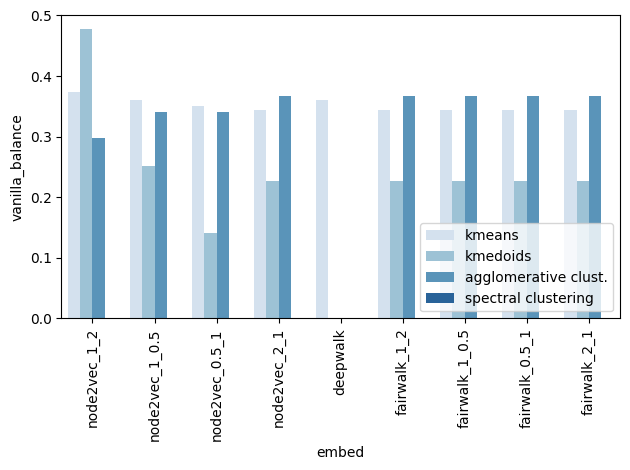

In [39]:
sns.barplot(x = 'embed',
            y = 'vanilla_balance',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("facebook_vanilla_balance.png")
plt.show()

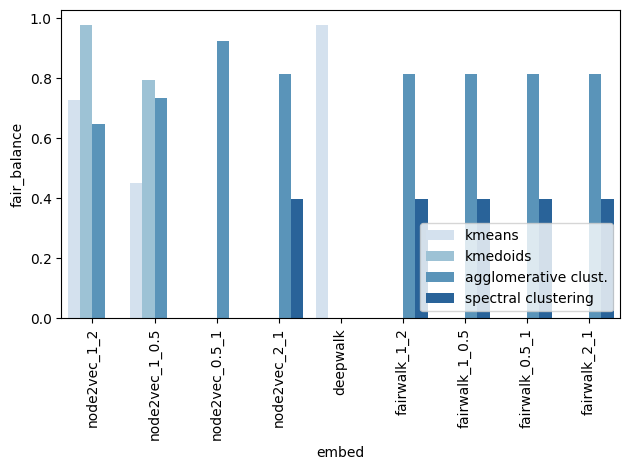

In [40]:
sns.barplot(x = 'embed',
            y = 'fair_balance',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("facebook_fair_balance.png")
plt.show()

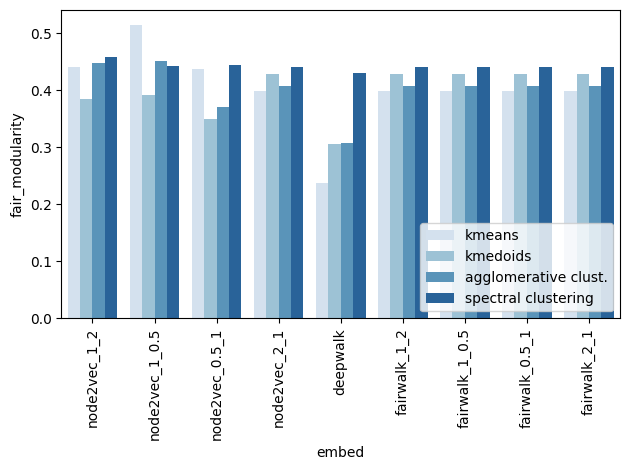

In [41]:
sns.barplot(x = 'embed',
            y = 'fair_modularity',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("facebooknet_fair_modularity.png")
plt.show()

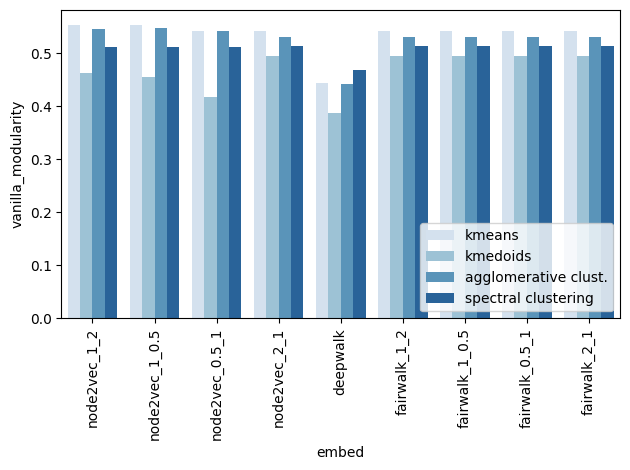

In [42]:
sns.barplot(x = 'embed',
            y = 'vanilla_modularity',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("facebooknet_vanilla_modularity.png")
plt.show()

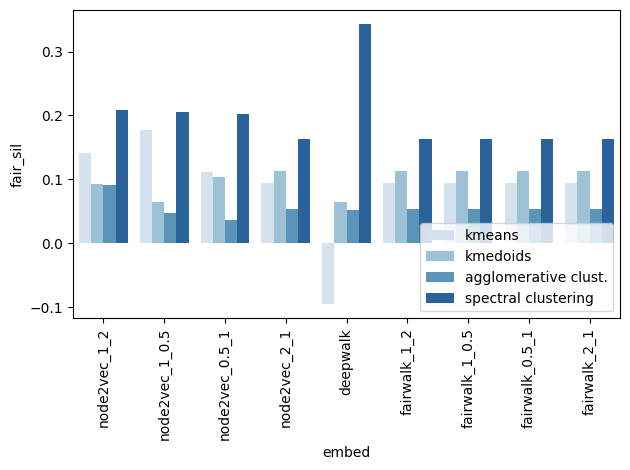

In [43]:
sns.barplot(x = 'embed',
            y = 'fair_sil',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("facebooknet_fair_sil.png")
plt.show()

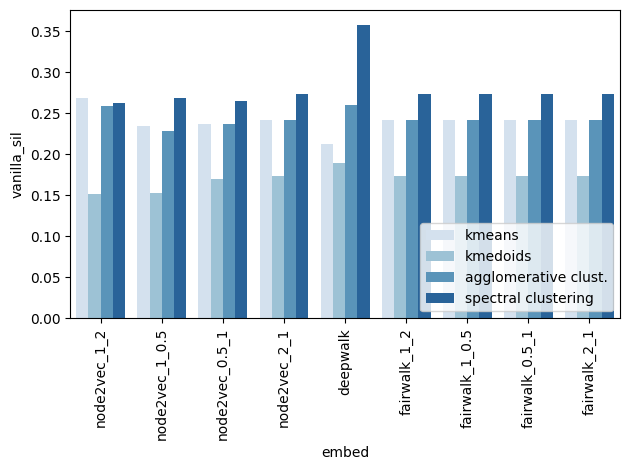

In [44]:
sns.barplot(x = 'embed',
            y = 'vanilla_sil',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("facebooknet_vanilla_sil.png")

plt.show()

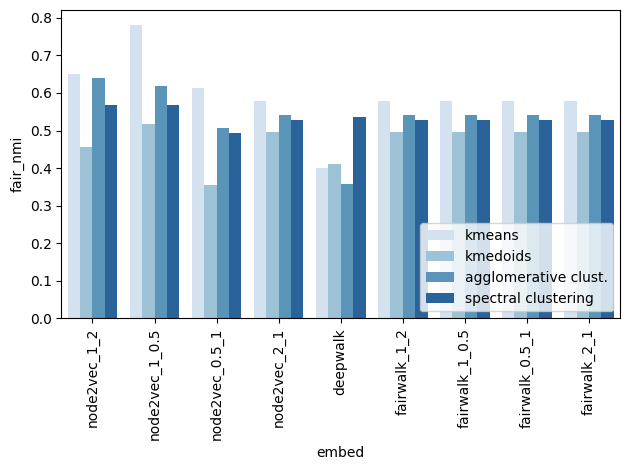

In [45]:
sns.barplot(x = 'embed',
            y = 'fair_nmi',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("facebooknet_fair_nmi.png")
plt.show()

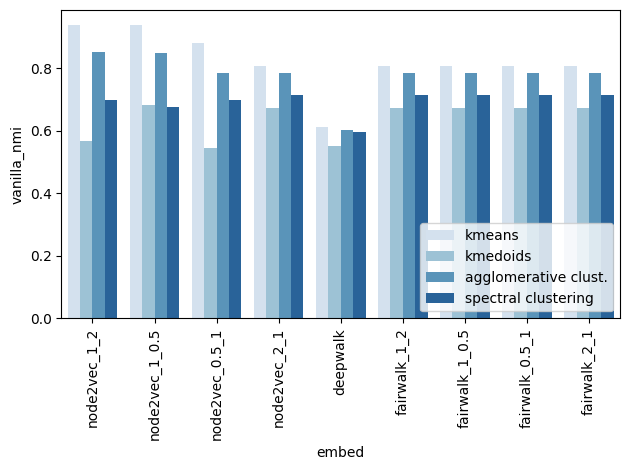

In [46]:
sns.barplot(x = 'embed',
            y = 'vanilla_nmi',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("facebooknet_vanilla_nmi.png")
plt.show()

## Fair clustering for DrugNet dataset
* drugnet dataset: https://sites.google.com/site/ucinetsoftware/datasets/covert-networks/drugnet

In [19]:
%%capture
%cd /content
!gdown 1LAVReNSOaXV4HbmqOOeec0XgiT5N99cq
!gdown 1UwucGGbw_SYRtywkdxhNakGAbn9qTOhL

In [40]:
adj_matrix = np.genfromtxt('DRUGNET.csv', delimiter=',')[1:,1:]

G = nx.from_numpy_matrix(adj_matrix, create_using=nx.Graph())
print(f"Init:\nnumber of nodes: {len(G.nodes())}, number of edges: {len(G.edges())}")

Init:
number of nodes: 293, number of edges: 284


In [41]:
# get ground truth clusters and groups
metadata = pd.read_csv('DRUGATTR.csv', sep=',')
metadata['node_id'] = metadata.index

# Remove nodes where there is no tie
no_tie_metadata = metadata.loc[metadata.HasTie==0]
no_tie_nodes = no_tie_metadata.node_id

metadata.drop(no_tie_metadata.index, inplace=True)
# Remove these nodes from graph too
G.remove_nodes_from(no_tie_nodes)

# Remove nodes where there is no tie
unk_group_metadata = metadata.loc[metadata.Gender==0]
unk_group_nodes = unk_group_metadata.node_id

metadata.drop(unk_group_metadata.index, inplace=True)
# Remove these nodes from graph too
G.remove_nodes_from(unk_group_nodes)

print(f'After removal of nodes with unkn group:\nnumber of nodes: {len(G.nodes())}, number of edges: {len(G.edges())}')

# Get the all the connected components in asc sort
conn_comps = list(sorted(nx.connected_components(G)))
largest_comp = conn_comps[0]
largest_subg = G.subgraph(largest_comp)
G = nx.Graph(largest_subg)
# remove the related rows from metadata
for cc in list(sorted(nx.connected_components(G)))[1:]:
 to_removed_metadata = metadata.loc[metadata.node_id.isin(list(cc))]
 metadata.drop(to_removed_metadata.index, inplace=True)

print(f'After getting the largest connected component:\nnumber of nodes: {len(G.nodes())}, number of edges: {len(G.edges())}')

# Relabel nodes to consecutive integers
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default')
# create node id in metadata to be aligned with G
metadata['node_id'] = np.arange(len(metadata))

After removal of nodes with unkn group:
number of nodes: 209, number of edges: 279
After getting the largest connected component:
number of nodes: 185, number of edges: 265


In [43]:
# Group together the 1, 5, 6, 7 = white or other labels as in the description of the dataset.
metadata.loc[metadata.Ethnicity.isin([5,6,7]), 'Ethnicity'] = 1
ethnicity = np.array([metadata.loc[metadata.node_id==node, 'Ethnicity'].iloc[0] for node in G.nodes()])

# Get the groups
colors = np.array([metadata.loc[metadata.node_id==node, 'Gender'].iloc[0] for node in G.nodes()])
unique_colors, counts = np.unique(colors, return_counts=True)
n_colors = len(unique_colors)
print(f"n_colors: {n_colors}, number of nodes per group: {counts}")

n_colors: 2, number of nodes per group: [149  36]


In [44]:
# Get louvain best modularity partitioning to define k
partition = community_louvain.best_partition(G, random_state=433)
lv_cl_labels = list(partition.values())

# Louvain clusters
unique_clusters, counts = np.unique(lv_cl_labels, return_counts=True)
n_clusters = len(unique_clusters)
print(f"Louvain:\nn_clusters: {n_clusters}, number of nodes per cluster: {counts/len(G.nodes())}")

Louvain:
n_clusters: 11, number of nodes per cluster: [0.11351351 0.07567568 0.11351351 0.07027027 0.08648649 0.04864865
 0.16756757 0.05945946 0.06486486 0.11891892 0.08108108]


In [45]:
# Get louvain partition modularity
lv_modularity = community_louvain.modularity(partition, G)
print(f'modularity: {lv_modularity:.3f}')

# Get louvain balance
total_points = len(lv_cl_labels)
group_fractions = np.array([np.sum(colors == color) / total_points for color in np.unique(colors)])
fair_group_distr = np.tile(group_fractions,(n_clusters, 1))
lv_group_distr = get_group_frac_per_cluster(lv_cl_labels, colors, n_clusters)
lv_balance = get_balance_score(fair_group_distr, lv_group_distr)
print(f'balance: {lv_balance}')

modularity: 0.711
balance: 0.395


In [46]:
# Init embedddings dict
embeds = {}

In [47]:
%%capture
# param pairs
params = [(1, 2, 15), (1, 0.5, 15), (0.5, 1, 15), (2, 1, 15)]

# Get node2vec embeddings
for param in params:
  p, q, walk_length = param
  n2v_emb = get_n2v_embed(G, p=p, q=q, walk_length=walk_length)
  embeds[f"node2vec_{p}_{q}"] = n2v_emb

In [48]:
%%capture
# get deepwalk embeddings
dw_emb = get_dw_embed(G, walk_length=walk_length)
embeds["deepwalk"] = dw_emb

In [49]:
%%capture
# param pairs
params = [(1, 2, 15), (1, 0.5, 15), (0.5, 1, 15), (2, 1, 15)]

# Get node2vec embeddings
for param in params:
  p, q, walk_length = param
  fw_emb = get_fw_embed(G, colors, p=p, q=q, walk_length=walk_length)
  embeds[f"fairwalk_{p}_{q}"] = n2v_emb

In [50]:
cl_algs = {
    'kmeans': vanilla_kmeans,
    'kmedoids': vanilla_kmedoid,
    'agglomerative clust.': vanilla_aggl_cl,
    'spectral clustering': vanilla_spectral_cl
    }

In [51]:
%%capture
res = pd.DataFrame(columns = ['embed', 'cl_alg', 'lv_balance', 'vanilla_balance', 'fair_balance', 'lv_modularity', 'vanilla_modularity', 'fair_modularity', 'lv_sil','vanilla_sil', 'fair_sil', 'vanilla_nmi', 'fair_nmi'])
for embed_name, embed in embeds.items():
  for cl_alg_name, cl_alg in cl_algs.items():
    vanilla_cl_labels, cl_dist_centers = cl_alg(embed, n_clusters=n_clusters)

    fair_cl_labels, fair_balance, vanilla_balance = post_processing_step(
        vanilla_cl_labels, colors, cl_dist_centers, embed
    )

    # Extract the communities from clustering
    vanilla_comm = cl_labels_to_communities(vanilla_cl_labels)
    fair_comm = cl_labels_to_communities(fair_cl_labels)

    cl_alg_res = {
        'embed': embed_name,
        'cl_alg': cl_alg_name,

        'lv_balance': lv_balance,
        'vanilla_balance': vanilla_balance,
        'fair_balance': fair_balance,

        'lv_modularity': round(lv_modularity, 3),
        'vanilla_modularity': round(nx.community.modularity(G, vanilla_comm), 3),
        'fair_modularity': round(nx.community.modularity(G, fair_comm), 3),

        'lv_sil': round(silhouette_score(embed, lv_cl_labels), 3),
        'vanilla_sil': round(silhouette_score(embed, vanilla_cl_labels), 3),
        'fair_sil':  round(silhouette_score(embed, fair_cl_labels), 3),

        'vanilla_nmi': round(normalized_mutual_info_score(lv_cl_labels, vanilla_cl_labels), 3),
        'fair_nmi': round(normalized_mutual_info_score(lv_cl_labels, fair_cl_labels), 3),
    }

    res = res.append(cl_alg_res, ignore_index = True)

In [52]:
res

,embed,cl_alg,lv_balance,vanilla_balance,fair_balance,lv_modularity,vanilla_modularity,fair_modularity,lv_sil,vanilla_sil,fair_sil,vanilla_nmi,fair_nmi
0,node2vec_1_2,kmeans,0.395,0.000,0.734,0.711,0.757,0.697,0.208,0.210,0.123,0.677,0.574
1,node2vec_1_2,kmedoids,0.395,0.000,0.000,0.711,0.729,0.627,0.208,0.078,0.042,0.590,0.416
2,node2vec_1_2,agglomerative clust.,0.395,0.000,0.000,0.711,0.771,0.681,0.208,0.231,0.107,0.791,0.608
3,node2vec_1_2,spectral clustering,0.395,0.000,0.571,0.711,0.710,0.635,0.208,0.243,0.125,0.700,0.554
4,node2vec_1_0.5,kmeans,0.395,0.395,0.623,0.711,0.783,0.711,0.236,0.247,0.118,0.739,0.621
5,node2vec_1_0.5,kmedoids,0.395,0.000,0.000,0.711,0.720,0.645,0.236,0.165,0.094,0.644,0.495
6,node2vec_1_0.5,agglomerative clust.,0.395,0.000,0.571,0.711,0.776,0.664,0.236,0.255,0.046,0.719,0.528
7,node2vec_1_0.5,spectral clustering,0.395,0.000,0.000,0.711,0.720,0.656,0.236,0.246,0.154,0.683,0.564
8,node2vec_0.5_1,kmeans,0.395,0.395,0.894,0.711,0.787,0.722,0.209,0.235,0.125,0.785,0.661
9,node2vec_0.5_1,kmedoids,0.395,0.000,0.000,0.711,0.734,0.654,0.209,0.081,0.057,0.575,0.435


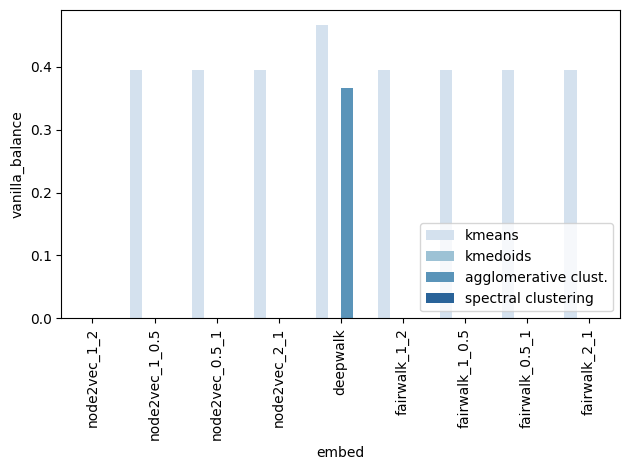

In [54]:
sns.barplot(x = 'embed',
            y = 'vanilla_balance',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("drugnet_vanilla_balance.png")
plt.show()

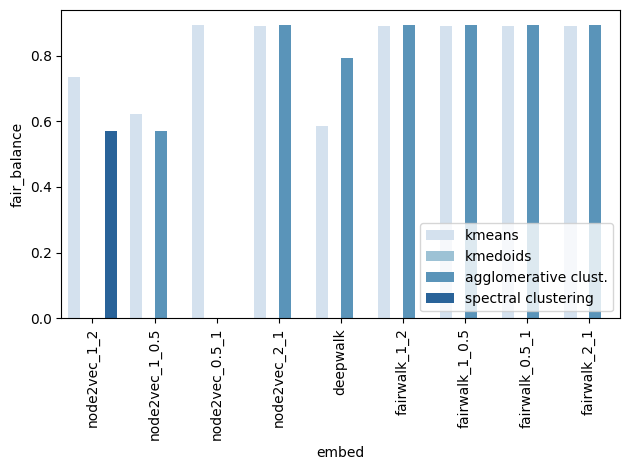

In [55]:
sns.barplot(x = 'embed',
            y = 'fair_balance',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("drugnet_fair_balance.png")
plt.show()

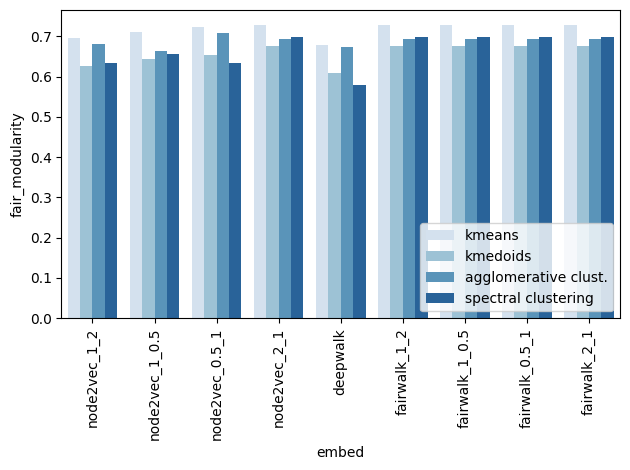

In [56]:
sns.barplot(x = 'embed',
            y = 'fair_modularity',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("drugnet_fair_modularity.png")
plt.show()

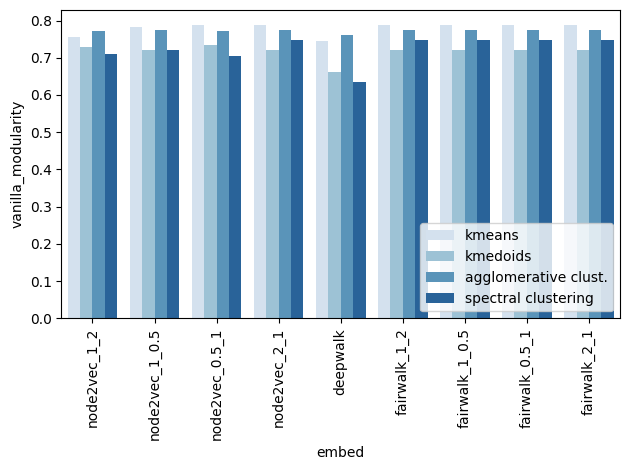

In [57]:
sns.barplot(x = 'embed',
            y = 'vanilla_modularity',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("drugnet_vanilla_modularity.png")
plt.show()

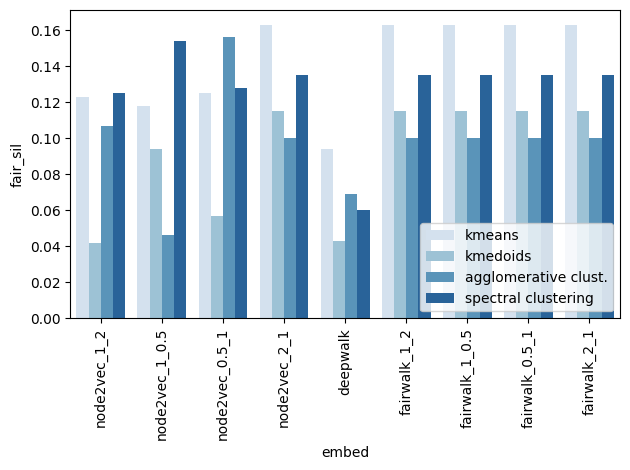

In [58]:
sns.barplot(x = 'embed',
            y = 'fair_sil',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("drugnet_fair_sil.png")
plt.show()

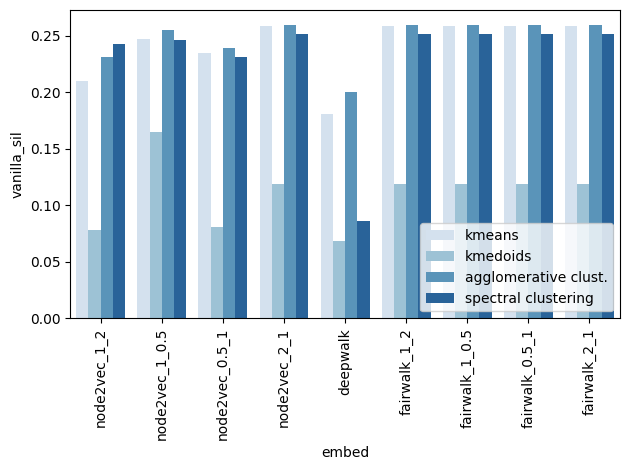

In [59]:
sns.barplot(x = 'embed',
            y = 'vanilla_sil',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("drugnet_vanilla_sil.png")

plt.show()

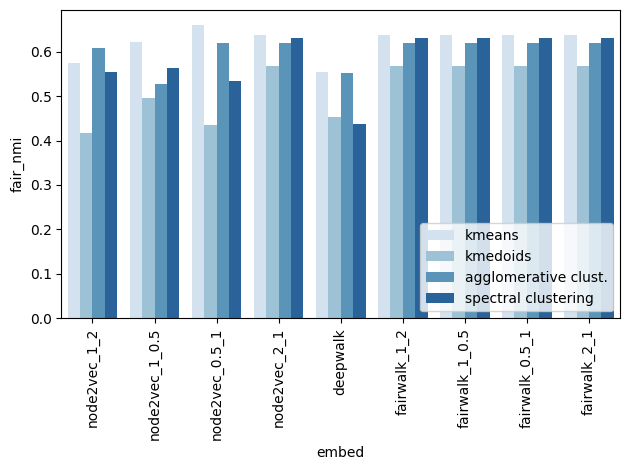

In [60]:
sns.barplot(x = 'embed',
            y = 'fair_nmi',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("drugnet_fair_nmi.png")
plt.show()

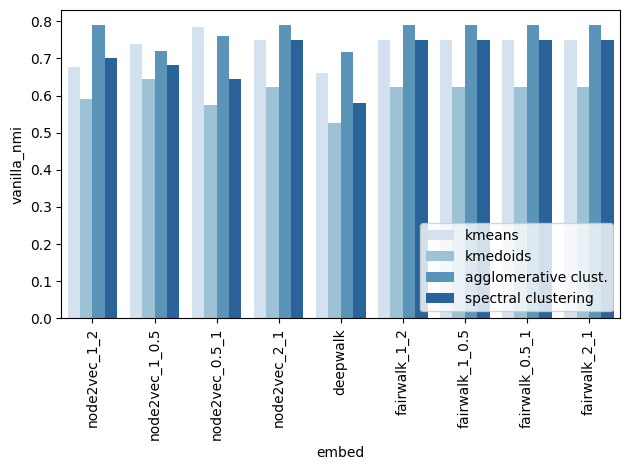

In [61]:
sns.barplot(x = 'embed',
            y = 'vanilla_nmi',
            hue = 'cl_alg',
            data = res,
            palette = "Blues")

plt.legend(loc='lower right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("drugnet_vanilla_nmi.png")
plt.show()